# Laboratorium 2 - szybkie menu
* '*' na początku nazwy funkcji oznacza pole z funckjami pomocniczymi - koniecznymi do poprawnego działania programu

#### *Podstawowe funkcje pomocnicze oraz importy konieczne do działania projektu

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
from math import cos, sin, pi
import time

first, second, third, fourth = None, None, None, None
TOLERANCE = 0,15

#############################################################################################################################################################################


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.
    
       
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

#############################################################################################################################################################################

# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()



#### Generowanie punktów z zadania 1 we wszystkich podpunktach w jednym miejscu

In [3]:
first = []
x = 100
y = 100
n = 100
for i in range(n):
    c = (random.uniform(-x, x), random.uniform(-y, y))
    first.append(c)
    
second = []
r = 10
x0 = 0
y0 = 0
n = 100
for i in range(n):
    alfa = random.uniform(0, 2 * pi)
    c = (x0 + r * sin(alfa), y0 + r * cos(alfa))
    second.append(c)

third = []
n = 100
x0 = -10
y0 = -10
x1 = 10
y1 = 10
for _ in range(n):
    curr = random.uniform(0,2*(x1-x0+y1-y0))
    if 0<=curr<=x1-x0:
        c = (x0 + curr, y0)
    elif x1-x0<curr<=x1-x0+y1-y0:
        curr -= x1-x0
        c = (x1, y0 + curr)
    elif x1-x0+y1-y0<curr<=2*(x1-x0)+y1-y0:
        curr -= x1-x0 + y1-y0
        c = (x1-curr, y1)
    elif 2*(x1-x0)+y1-y0<curr<=2*(x1-x0+y1-y0):
        curr -= 2*(x1-x0)+y1-y0
        c = (x0, y1-curr)
    third.append(c)


n = 25
m = 20
x0 = -10
y0 = -10
a = 20
fourth = [(x0,y0), (x0+a, y0), (x0,y0+a), (x0+a, y0+a)]
for _ in range(n):
    curr = random.uniform(0, 2*a)
    if 0 <= curr <= a:
        c = (x0+curr, y0)
    elif a < curr <= 2*a:
        curr -= a
        c = (x0, y0 + curr)
    fourth.append(c)
for _ in range(m):
    curr = random.uniform(0, 2*a)
    if 0 <= curr <= a:
        c = (x0+curr, y0+curr)
    elif a < curr <= 2*a:
        curr -= a
        c = (x0+curr, y0 + a - curr)
    fourth.append(c)


#### Wizualizacja wszystkich podpunktów

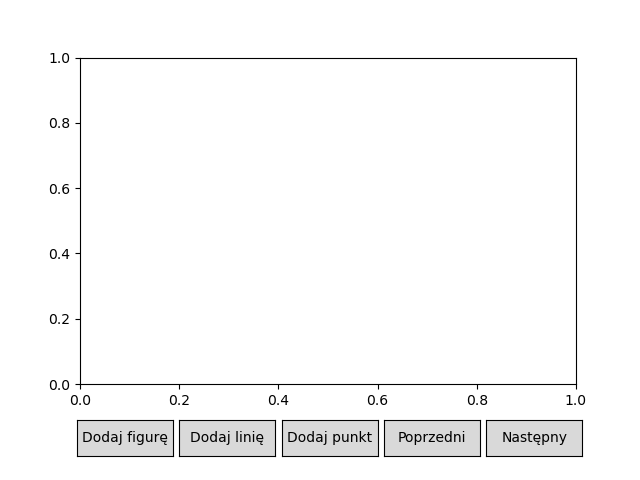

In [3]:
if first and second and third and fourth:
    scenes = [

        Scene([PointsCollection(first, color='blue')]),

        Scene([PointsCollection(second, color='red')]),
        
        Scene([PointsCollection(third, color='green')]),
        
        Scene([PointsCollection(fourth, color='yellow')]),

    ]
    plot = Plot(scenes=scenes)
    plot.draw()
else:
    print("Żeby móc włączyć wszystkie wizualizacje, najpierw włącz każdą z kolei")
    print("Brak:")
    if not first: print("first")
    if not second: print("second")
    if not third: print("third")
    if not fourth: print("fourth")

# Generowanie punktów

## Zadanie 1 
- Z góry zadana ilość punktów oraz przedziały


Przygotuj program generujący następujące zbiory punktów na płaszczyźnie(współrzędne typu double):

a) zawierający 100 losowo wygenerowanych punktów o współrzędnych z przedziału [-100, 100],

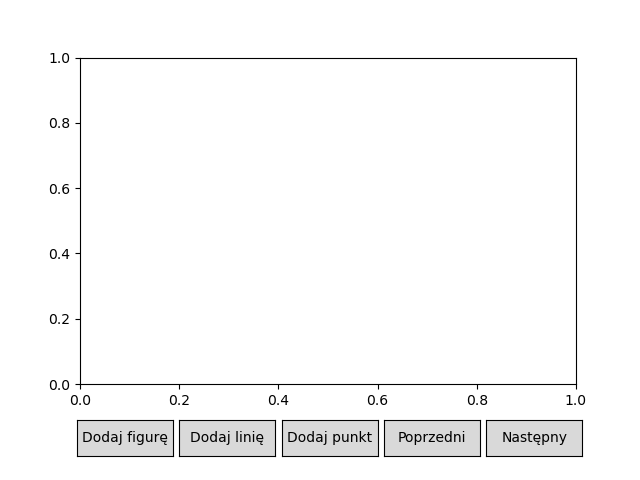

In [20]:
# zaznaczam startowe punkty
a = (-1.0, 0.0)
b = (1.0, 0.1)
starting = [a, b]

#
# w podpunkcie a losuje punkty z zadanego przedziału
first = []
x = 100
y = 100
n = 100
for i in range(n):
    c = (random.uniform(-x, x), random.uniform(-y, y))
    first.append(c)

scenes = [

    Scene([PointsCollection(first, color='blue')]),

]

plot = Plot(scenes=scenes)
plot.draw()

b) zawierający 100 losowo wygenerowanych punktów leżących na okręgu o środku
(0,0) i promieniu R=10,

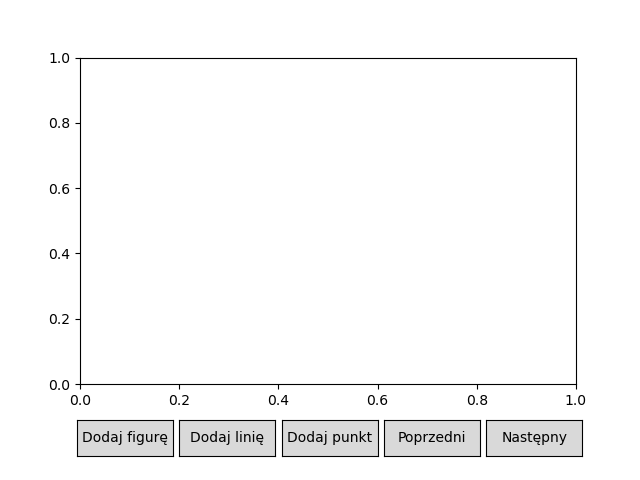

In [115]:
#
# do obliczenia podpunktu b używam równania parametrycznego okręgu
second = []
r = 10
x0 = 0
y0 = 0
n = 100
for i in range(n):
    alfa = random.uniform(0, 2 * pi)
    c = (x0 + r * sin(alfa), y0 + r * cos(alfa))
    second.append(c)

scenes = [

    Scene([PointsCollection(second, color='red')]),

]

plot = Plot(scenes=scenes)
plot.draw()

c) zawierający 100 losowo wygenerowanych punktów leżących na bokach prostokąta
o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10),

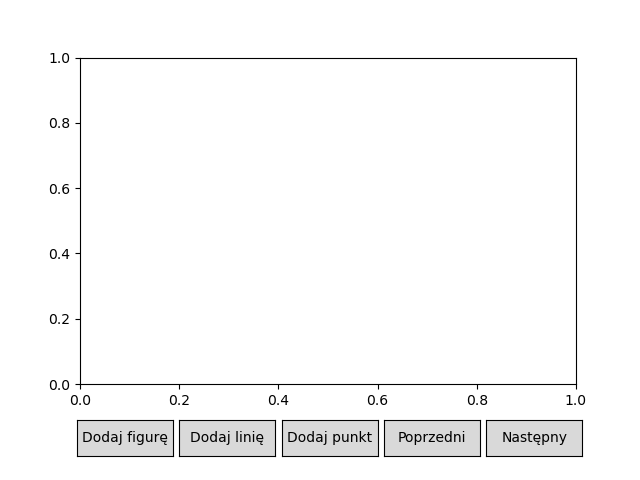

In [116]:
#
# do obliczenia trzciego podpunktu "prostuję" prostokąt, losując liczby na jego obwodzie i dodaję do odpowiedniej krawędzi
third = []
n = 100
x0 = -10
y0 = -10
x1 = 10
y1 = 10
for _ in range(n):
    curr = random.uniform(0,2*(x1-x0+y1-y0))
    if 0<=curr<=x1-x0:
        c = (x0 + curr, y0)
    elif x1-x0<curr<=x1-x0+y1-y0:
        curr -= x1-x0
        c = (x1, y0 + curr)
    elif x1-x0+y1-y0<curr<=2*(x1-x0)+y1-y0:
        curr -= x1-x0 + y1-y0
        c = (x1-curr, y1)
    elif 2*(x1-x0)+y1-y0<curr<=2*(x1-x0+y1-y0):
        curr -= 2*(x1-x0)+y1-y0
        c = (x0, y1-curr)
    third.append(c)

scenes = [
    
    Scene([PointsCollection(third, color='green')]),

]

plot = Plot(scenes=scenes)
plot.draw()

d) zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty
wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach
kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu

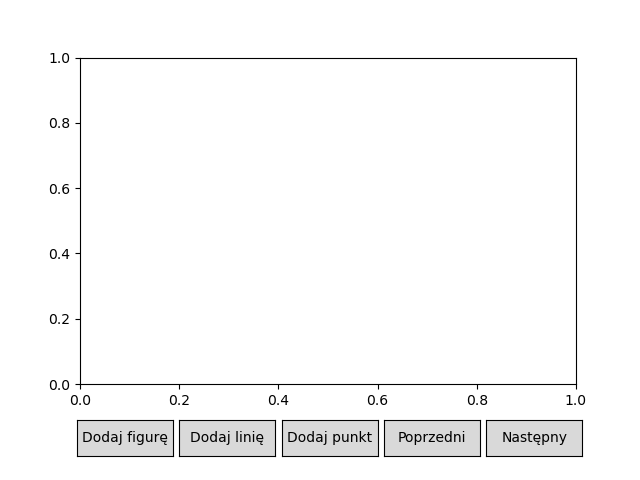

In [117]:
#
# metoda podobna jak w podpunkcie trzecim

n = 25
m = 20
x0 = -10
y0 = -10
a = 20
fourth = [(x0,y0), (x0+a, y0), (x0,y0+a), (x0+a, y0+a)]
for _ in range(n):
    curr = random.uniform(0, 2*a)
    if 0 <= curr <= a:
        c = (x0+curr, y0)
    elif a < curr <= 2*a:
        curr -= a
        c = (x0, y0 + curr)
    fourth.append(c)

for _ in range(m):
    curr = random.uniform(0, 2*a)
    if 0 <= curr <= a:
        c = (x0+curr, y0+curr)
    elif a < curr <= 2*a:
        curr -= a
        c = (x0+curr, y0 + a - curr)

    fourth.append(c)

scenes = [
    
    Scene([PointsCollection(fourth, color='yellow')]),

]

plot = Plot(scenes=scenes)
plot.draw()

## Zadanie 3
- Zmodyfikuj program z punktu 1 tak, aby możliwe było zadawanie określonych parametrów dla schematów losowania punktów podanych powyżej:
- Samodzielne ustalanie ilości punktów oraz przedziałów


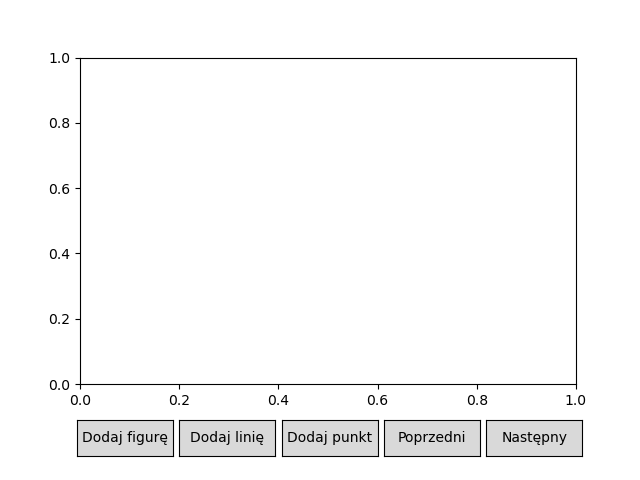

In [24]:
# w podpunkcie a losuje punkty z zadanego przedziału

first = []
a  = int(input("Wprowadź przedział dla współrzędnych od:"))
b  = int(input("Wprowadź przedział dla współrzędnych do:"))
n = int(input("Wprowadź ilość zmiennych"))

for i in range(n):
    c = (random.uniform(a, b), random.uniform(a, b))
    first.append(c)

scenes = [

    Scene([PointsCollection(first, color='blue')]),
    
]

plot = Plot(scenes=scenes)
plot.draw()

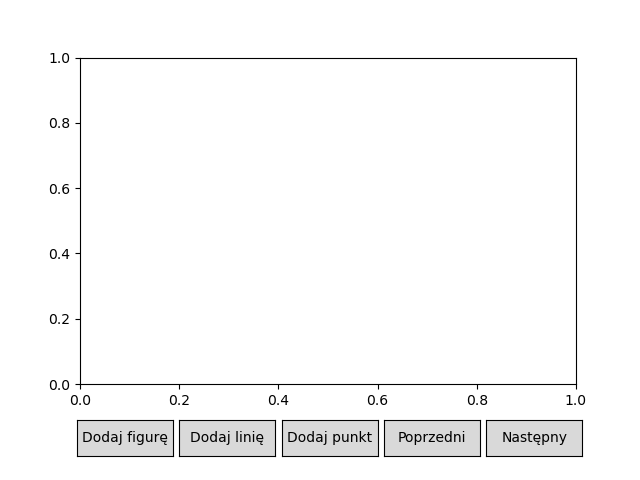

In [119]:
#
# do obliczenia podpunktu b używam równania parametrycznego okręgu
second = []
x0 = int(input("Wprowadź współrzędną x punktu startowego"))
y0 = int(input("Wprowadź współrzędną y punktu startowego"))
r = int(input("Wprowadź promień okręgu"))
n = int(input("Wprowadź ilość punktów"))

for i in range(n):
    alfa = random.uniform(0, 2 * pi)
    c = (x0 + r * sin(alfa), y0 + r * cos(alfa))
    second.append(c)

scenes = [

    Scene([PointsCollection(second, color='red')]),

]

plot = Plot(scenes=scenes)
plot.draw()

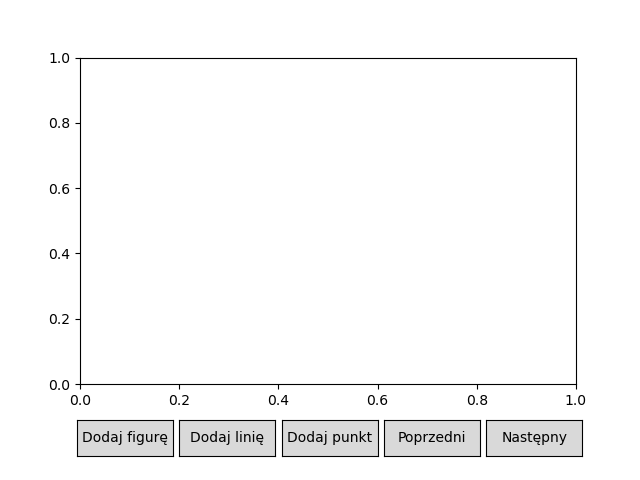

In [121]:
#
# do obliczenia trzciego podpunktu "prostuję" prostokąt, losując liczby na jego obwodzie i dodaję do odpowiedniej krawędzi
third = []
n = int(input("Wprowadź ilość punktów"))
x0 = int(input("Wprowadź współrzędną x punktu lowLeft"))
y0 = int(input("Wprowadź współrzędną y punktu lowLeft"))
x1 = int(input("Wprowadź współrzędną x punktu upRight"))
y1 = int(input("Wprowadź współrzędną y punktu upRight"))

for _ in range(n):
    curr = random.uniform(0,2*(x1-x0+y1-y0))
    if 0<=curr<=x1-x0:
        c = (x0 + curr, y0)
    elif x1-x0<curr<=x1-x0+y1-y0:
        curr -= x1-x0
        c = (x1, y0 + curr)
    elif x1-x0+y1-y0<curr<=2*(x1-x0)+y1-y0:
        curr -= x1-x0 + y1-y0
        c = (x1-curr, y1)
    elif 2*(x1-x0)+y1-y0<curr<=2*(x1-x0+y1-y0):
        curr -= 2*(x1-x0)+y1-y0
        c = (x0, y1-curr)
    third.append(c)

scenes = [
    
    Scene([PointsCollection(third, color='green')]),

]

plot = Plot(scenes=scenes)
plot.draw()

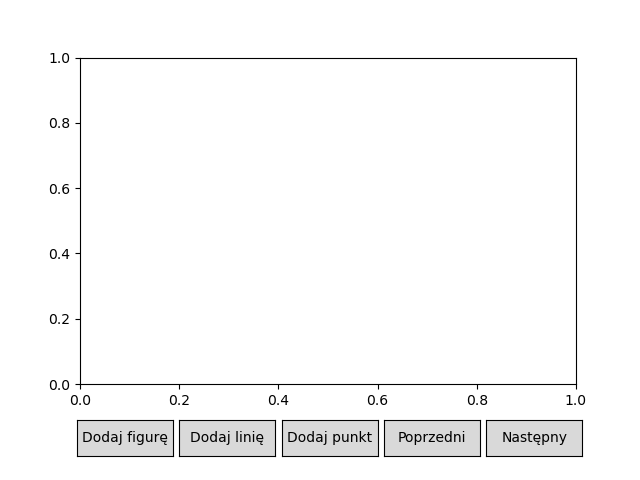

In [ ]:
# metoda podobna jak w podpunkcie trzecim
n = int(input("Wprowadź ilość punktów na bokach kwadratu"))
m = int(input("Wprowadź ilość punktów na przekątnych kwadratu"))
x0 = int(input("Wprowadź współrzędną x punktu lowLeft"))
y0 = int(input("Wprowadź współrzędną y punktu lowLeft"))
a = int(input("Długość boku"))
fourth = [(x0,y0), (x0+a, y0), (x0,y0+a), (x0+a, y0+a)]
for _ in range(n):
    curr = random.uniform(0, 2*a)
    if 0 <= curr <= a:
        c = (x0+curr, y0)
    elif a < curr <= 2*a:
        curr -= a
        c = (x0, y0 + curr)
    fourth.append(c)

for _ in range(m):
    curr = random.uniform(0, 2*a)
    if 0 <= curr <= a:
        c = (x0+curr, y0+curr)
    elif a < curr <= 2*a:
        curr -= a
        c = (x0+curr, y0 + a - curr)

    fourth.append(c)

scenes = [
    
    Scene([PointsCollection(fourth, color='yellow')]),

]

plot = Plot(scenes=scenes)
plot.draw()

# Tworzenie otoczki wypukłej

### *funkcje pomocnicze wykorzystywane w obu algorytmach generujących otoczkę wypukłą

In [4]:
from collections import deque
from functools import cmp_to_key

def lowest_point(points):
    global min_point 
    min_point = points[0]
    for element in points:
        if min_point[0] > element[0]:
            min_point = element
        elif min_point[0] == element[0]:
            if min_point[1] < element[1]:
                min_point = element


def orient(a, b, c):
    res = (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])
    if res > 0:
        return 1
    elif res < 0:
        return -1
    return 0

######################################## VISUALIZATION ###############################################

def visualize(points, deq, wannabe_points, last):
        scenes.append(Scene( [
        PointsCollection(points.copy(), color='blue'), 
        PointsCollection(deq.copy(), color='red'), 
        PointsCollection(wannabe_points.copy(), color='purple')],
        [
        LinesCollection(make_lines(deq, last), color='red'), 
        LinesCollection(make_wannabe_lines(deq, wannabe_points), color='purple')]
        ) )

def make_lines(tab, last):
    result = []
    for i in range(1, len(tab)):
        result.append((tab[i-1], tab[i]))
    if last: result.append((tab[-1],tab[0]))
    return result

def make_wannabe_lines(deq, tab):
    result = []
    # if len(deq)>0: result.append((deq[-1], tab[0]))
    for i in range(1, len(tab)):
        result.append((tab[i-1], tab[i]))
    return result

## Algorytm Grahama

### *funkcje pomocnicze wykorzystywane w algorytmie Grahama

In [5]:
def distance_square(point1, point2):
    return np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2)

def orient_sort(b, c):
    a = min_point
    res = (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])
    if res > 0:
        return 1
    elif res < 0:
        return -1

    elif distance_square(a,b) < distance_square(a,c):
        return -1
    else:
        return 1
    

def sort_by_angle(points):
    return sorted(points, key=cmp_to_key(orient_sort))

### Zadana wizualizacja algorytmu Grahama

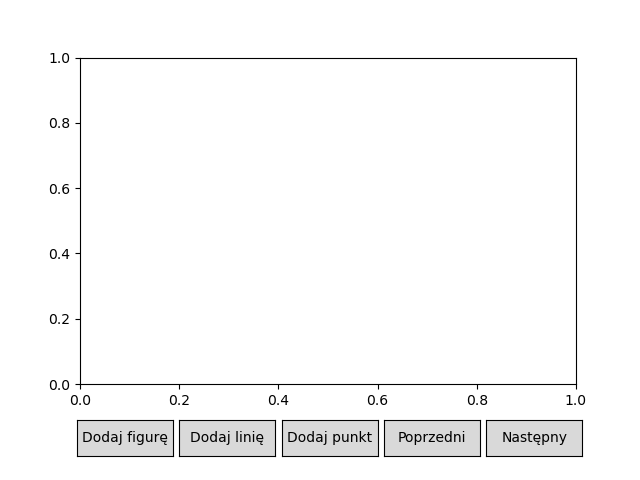

CZAS WYKONANIA PROGRAMU TO: 0.29859209060668945 s


In [21]:
scenes = []
string_points = input("Wprowadź literę podpunktu")

if string_points == "a":
        interesting_points = first
elif string_points == "b":
        interesting_points = second
elif string_points =="c":
        interesting_points = third
elif string_points =="d":
    interesting_points = fourth
else:
    print("Nie ma takiego zadania")

start_time = time.time()

def graham(points):
    deq = deque()
    wannabe_points = deque()
    lowest_point(points)
    new_points = sort_by_angle(points)

    deq.append(new_points[0]) # guaranteed to be on hull, lowest-x element
    visualize(points, deq, wannabe_points, False)
    deq.append(new_points[1]) # wannabe hull
    wannabe_points.append(new_points[1])
    visualize(points, deq, wannabe_points, False)
    for i in range(2, len(new_points)):
        next_point = new_points[i] # wannabe hull
        p_point = deq.pop()
        wannabe_points.append(p_point)
        while len(deq) > 0 and orient(p_point, next_point, deq[-1]) >= 0:
            p_point = deq.pop() # delete bad turn or collinear
            while wannabe_points: wannabe_points.pop() #delete wannabe
        if len(deq) > 0: wannabe_points.append(deq[-1])
        wannabe_points.append(p_point)
        wannabe_points.append(next_point)
        visualize(points, deq, wannabe_points, False)
        deq.append(p_point)
        deq.append(new_points[i])
        
    p_point = deq.pop() # wannabe
    wannabe_points.append(p_point)
    visualize(points, deq, wannabe_points, False)
    if orient( p_point, min_point, deq[-1]) != 0: # last el can be collineal
        deq.append(p_point)
        while wannabe_points: wannabe_points.pop() #delete wannabe
        visualize(points, deq, wannabe_points, False)
    
    
    visualize(points, deq, wannabe_points, True)
    return deq


graham_deque = graham(interesting_points)

plot = Plot(scenes=scenes)
plot.draw()

print("CZAS WYKONANIA PROGRAMU TO:", time.time() - start_time, 's')

## Algorytm Jarvisa

### Zadana wizualizacja algorytmu Jarvisa

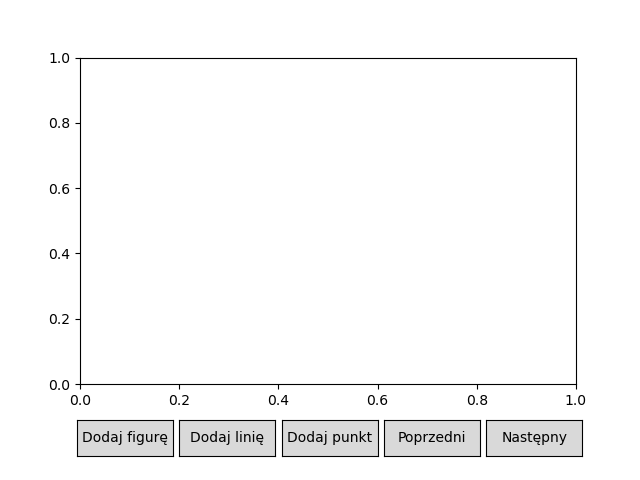

CZAS WYKONANIA PROGRAMU TO: 1.1967129707336426 s


In [19]:
scenes = []
start_time = time.time()

string_points = input("Wprowadź literę podpunktu")

if string_points == "a":
        interesting_points = first
elif string_points == "b":
        interesting_points = second
elif string_points =="c":
        interesting_points = third
elif string_points =="d":
    interesting_points = fourth
else:
    print("Nie ma takiego zadania")

def jarvis(points):
    hull = deque()
    lowest_point(points)
    hull.append(min_point)
    prev_vertex = min_point
    
    wannabe_points = deque()

    while(True):
        candidate = None
        wannabe_points.append(prev_vertex)
        for point in points:
            wannabe_points = deque()
            wannabe_points.append(prev_vertex)
            if point == prev_vertex: continue
            if candidate == None: 
                candidate = point
            wannabe_points.append(candidate)
            wannabe_points.append(point)
            orientation = orient(prev_vertex, candidate, point)
            visualize(points, hull, wannabe_points, False)
            if orientation == 0 and dist(prev_vertex, candidate) < dist(prev_vertex, point):
                candidate = point
            elif orientation < 0:
                candidate = point
        if candidate == min_point:
            while wannabe_points: wannabe_points.pop() #delete wannabe
            visualize(points, hull, wannabe_points, True)
            break
        hull.append(candidate)
        while wannabe_points: wannabe_points.pop() #delete wannabe
        visualize(points, hull, wannabe_points, False)
        prev_vertex = candidate
    return hull

jarvis_deque = jarvis(interesting_points)

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

plot = Plot(scenes=scenes)
plot.draw()
print("CZAS WYKONANIA PROGRAMU TO:", time.time() - start_time, 's')

# Mierzenie czasu

### Obliczanie czasu realizacji algorytmów wraz z wizualizacją

PODPUNKT b PUNKTÓW n+m CZAS WYKONANIA AlGORYTMU JARVISA TO: 0.00940561294555664 s
PODPUNKT b PUNKTÓW n+m CZAS WYKONANIA ALGORYTMU GRAHAMA TO: 0.0015072822570800781 s


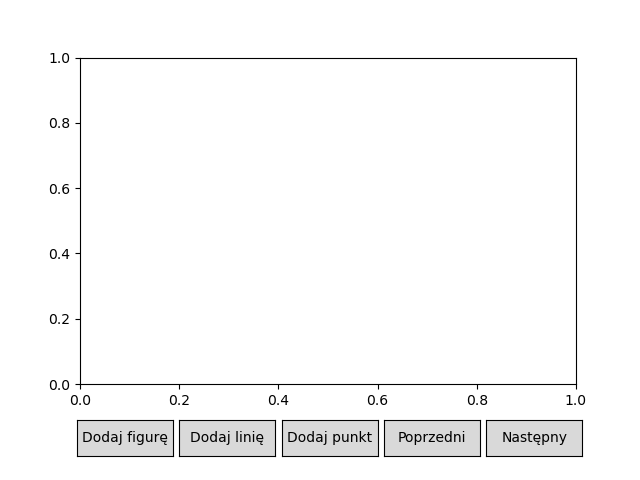

In [12]:
string_points = input("Wprowadź literę podpunktu")

if string_points == "a":
        interesting_points = first
elif string_points == "b":
        interesting_points = second
elif string_points =="c":
        interesting_points = third
elif string_points =="d":
    interesting_points = fourth
else:
    print("Nie ma takiego zadania")

start_time = time.time()
scenes = []
def jarvis(points):
    hull = deque()
    lowest_point(points)
    hull.append(min_point)
    prev_vertex = min_point

    while(True):
        candidate = None
        for point in points:
            if point == prev_vertex: continue
            if candidate == None: candidate = point
            orientation = orient(prev_vertex, candidate, point)
            if orientation == 0 and dist(prev_vertex, candidate) < dist(prev_vertex, point):
                candidate = point
            elif orientation < 0:
                candidate = point
        if candidate == min_point: break
        hull.append(candidate)
        prev_vertex = candidate
    return hull

jarvis_deque = jarvis(interesting_points.copy())
print("PODPUNKT", string_points, "PUNKTÓW", n, "CZAS WYKONANIA AlGORYTMU JARVISA TO:", time.time() - start_time, 's')


start_time = time.time()

def graham(points):
    deq = deque()
    lowest_point(points)
    new_points = sort_by_angle(points)
    deq.append(new_points[0]) # guaranteed to be on hull, lowest-x element
    deq.append(new_points[1]) # wannabe hull
    for i in range(2, len(new_points)):
        next_point = new_points[i] # wannabe hull
        p_point = deq.pop()
        while len(deq) > 0 and orient(p_point, next_point, deq[-1]) >= 0:
            p_point = deq.pop() # delete bad turn or collinear
        deq.append(p_point) # wannabe
        deq.append(new_points[i]) # wannabe

    p_point = deq.pop() # wannabe
    if orient( p_point, min_point, deq[-1]) != 0: # last can be collineal
        deq.append(p_point) # guarantee
    return deq

graham_deque = graham(interesting_points.copy())
print("PODPUNKT", string_points,"PUNKTÓW", n,"CZAS WYKONANIA ALGORYTMU GRAHAMA TO:", time.time() - start_time, 's')

scenes.append(Scene( [
        PointsCollection(interesting_points.copy(), color='blue'), 
        PointsCollection(jarvis_deque.copy(), color='red')],
        [
        LinesCollection(make_lines(jarvis_deque.copy(), True), color='red')]
        ) 
        )

scenes.append(Scene( [
        PointsCollection(interesting_points.copy(), color='blue'), 
        PointsCollection(graham_deque.copy(), color='pink')],
        [
        LinesCollection(make_lines(graham_deque.copy(), True), color='pink')]
        ) 
        )

plot = Plot(scenes=scenes)
plot.draw()
